# Training language models to follow instructions
# with human feedback

## Abstract：
### 问题 & 解决：
* 问题：更大的模型有时并不意味着能够更好地遵循用户的意图，生成的输出可能是不真实的、有害的或对用户没有帮助的

* 解决：本文提到，通过利用人类反馈进行微调，在广泛的任务中使语言模型与用户意图保持一致；生成的模型称为 InstructGPT

* 结果：在公共NLP数据集上，InstructGPT模型显示出真实性的提高和有毒输出的减少，同时具有最小的性能回归。尽管InstructGPT仍然会犯一些简单的错误，但我们的结果表明，根据人类反馈进行微调是使语言模型与人类意图保持一致的一个有希望的方向

</br>
</br>



## 分析问题：
出现模型不遵循用户指示的原因在于：许多LM的目的是进行预测，而非准确无误地遵循指示。因此，本文提到语言模型的目的是不一致的，而避免这类问题在模型中十分重要

## 实现 InstructGPT:
### 目的：训练语言模型按照用户的意图行事，既包括明确的意图，如遵循指示，也包括隐含的意图，如使模型保持诚实，不偏见，不具有负面效果（有毒）……
  * helpful：模型能够帮助人类
  
  * honest：模型提供的信息并不是编造的
  
  * harmless：模型不对人类或社会在任何角度造成伤害

### 方法：
对语言模型进行微调，使用基于人类反馈的强化学习（RLHF: reinforcement learning from human feedback）来微调GPT-3，该技术使用人类偏好作为奖励信号（reward signal）来微调我们的模型
  
### 具体步骤：   
  * 图示：   
  
 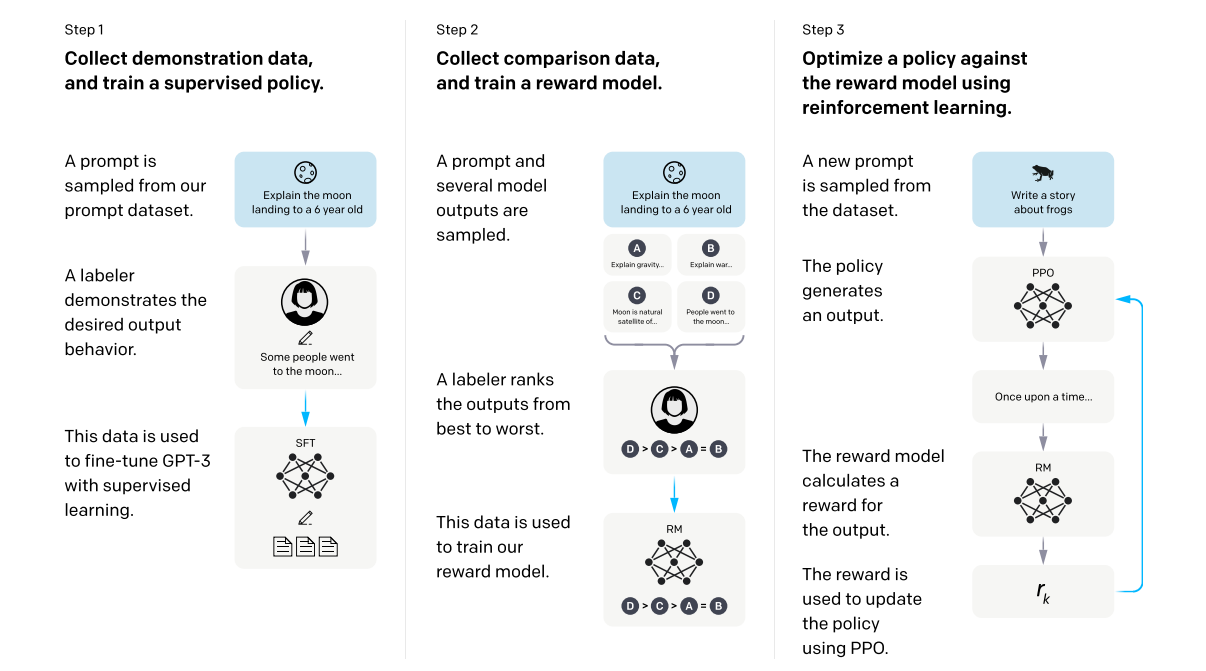

#### Step 1：
  * 该步骤的主要任务是：**收集人工的表示性数据（demonstration data），用监督学习的方法训练GPT模型**
  
  1. 从数据集中生成 prompt
   
  2. 告知人类提供给模型的 prompt 提示，收集人类所期待模型做出的 output 
   
  3. 用2步收集到的数据来进行 supervised learning，训练模型

#### Step 2：
  * 该步骤的主要任务是：**向模型输入 prompt，收集 prompt以及模型的outputs 作为数据集，依据该数据集训练一个 reward model**
  
  1. 收集数据，形成数据集
   
  2. labeler 评价数据集的输出

  3. 用1得到的数据集 + 2得到的评分训练RM，从而使 RM 具有预测labeler更喜欢哪种output的能力

#### Step 3：
  * 该步骤的主要任务：**使用强化学习（reinforcement learning）来最大化 Step 2 中RM预测的“奖励（reward）”**

  1. 依据数据集得到新的 prompt
   
  2. 输入prompt，得到output
   
  3. Step 2 中得到的RM给output打分
   
  4. 使用PPO算法，利用3中得到的reward，更新模型

### 结果：InstructGPT 效果超过其它GPT模型，图示如下（ppo 即为：InstructGPT）   
     
  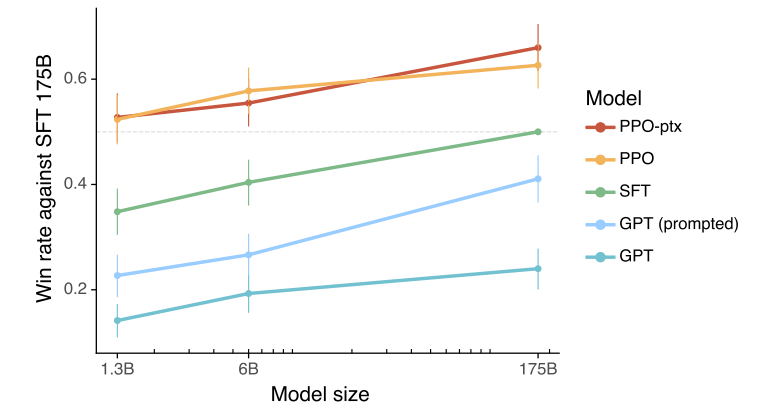

#### 注释：PPO算法 & 强化学习
* PPO算法，即近端策略优化算法 Proximal Policy Optimization，是OpenAI提出的算法，OpenAI在做尝试的时候，首选PPO。可想而知，PPO可能不是目前最强的，但可能是目前来说适用性最广的一种算法

* 参考：https://zhuanlan.zhihu.com/p/614115887

</br>
</br>

<style>
    p{
        line-height: 2.0
    }
</style>

## Findings（实验总结）:

### labelers 明显更喜欢 InstructGPT
* <p>参与测试的模型具有相同的体系结构，不同之处在于InstructGPT对我们的人类数据进行了微调。即使我们在GPT-3中添加几次提示以使其更好地遵循指示，labeler仍然明显更喜欢 InstructGPT。我们的175B InstructGPT输出在85±3%的时间内优于175B GPT-3输出，在71±4%的时间内优于少量的175B GPT-3输出。</p>

* InstructGPT模型还根据labelers生成更合适的输出，并且更可靠地遵循指令中的显式约束。
  
</br>

### 与GPT-3相比，InstructGPT具有更好的真实性
* 在TruthfulQA基准测试中，InstructGPT生成真实且信息丰富的答案的频率是GPT-3的两倍

</br>

### 在output的负面性（toxicity）上，InstructGPT有小改善，但没有 bias（？：偏置）
* <p>为了测量毒性，本文使用RealToxicityPrompts数据集并进行 自动和人工 评估。当提示 respectful时（？：我理解为prompt相对于任务来说是严谨的），InstructGPT模型产生的有毒输出比GPT-3少25%。在Winogender和CrowSPairs数据集上，InstructGPT与GPT-3相比没有显著改善

</br>

### 可以通过修改我们的RLHF微调过程，来最小化公共NLP数据集上的性能回归
* <p>在RLHF微调期间，我们观察到与GPT-3相比，在某些公共NLP数据集上的性能回归。这是 alignment tax 的案例，即进行调整的代价是在一些我们在意的任务上的性能下降

* <p>可以通过将 PPO带来的更新 和 那些能够增加预训练分布(PPO-ptx)的日志似然（log likelihood）的更新 混合，来大大减少这些数据集上的性能回归，并且不会影响labeler的偏好得分

</br>

### 模型具有推广性
* 在测试模型的泛化能力的测试中，对那些并没有产生任何测试数据的labeler（即：被训练排除的labeler），InstructGPT相比于其它模型依然有更好的效果

* 理解：正如前文所说InstructGPT的构建是基于人类偏好的，所以即使这些labeler被排除在测试之外，他们依然具有人类的偏好，所以InstructGPT会具有优势

</br>

### 公共NLP数据集不能反映我们的语言模型
* <p>比较 基于InstructGPT上进行微调的GPT-3 与 基于两种不同的公共NLP任务编译GPT-3: FLAN 和 T0 发现：在我们的API提示分布（prompt distribution）上，我们的 FLAN 和 T0 模型的表现略差于我们的SFT baseline，而labeler明显更喜欢InstructGPT而不是这些模型(与我们的baseline相比，InstructGPT的胜率为73.4±2%，而我们的T0和FLAN版本分别为26.8±2%和29.8±2%)
  
* 数据集由各种NLP任务结合每个任务的自然语言指令构成

</br>

### InstructGPT模型对RLHF调优分布之外的指令很可能具有泛化性
* <p>考察InstructGPT的功能发现：它能够遵循总结代码的指令，回答关于代码的问题，有时还会遵循不同语言的指令，尽管这些指令在微调训练中非常罕见。相比之下，GPT-3可以执行这些任务，但需要更仔细的提示，并且通常不遵循这些领域的指示

* 这个结果表明模型能够理解 “遵循指令” 的概念。即使在很少得到直接监督信号的任务上，模型也会保持一定的 alignment（对任务的适应性）

</br>

### InstructGPT模型仍然会犯一些简单的错误
* <p>InstructGPT仍然可能无法遵循指令，编造事实，对简单的问题给出冗长的模棱两可的答案，或者无法检测带有错误前提的指令

</br>

## 总结
使用人类偏好对大型语言模型进行微调可以显著改善它们在广泛任务中的行为，但提高它们的安全性和可靠性还有很多工作